In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [34]:
!pip install xgboost

In [12]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("Churn.csv")

Saving Churn.csv to Churn (1).csv


In [13]:
# Drop customerID
if "customerID" in df.columns:
    df.drop("customerID", axis=1, inplace=True)

In [14]:
# Convert TotalCharges
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df.dropna(inplace=True)

In [15]:
# Encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

In [16]:
# Split data
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
# Train RandomForest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


RandomForestClassifier()

In [19]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [08:29:45] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [21]:
# Evaluate
rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

print("\nXGBoost Results:")
print(classification_report(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))



Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

ROC AUC: 0.8156736777259528

XGBoost Results:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1033
           1       0.57      0.49      0.52       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.68      1407
weighted avg       0.75      0.76      0.76      1407

ROC AUC: 0.8075668708035886


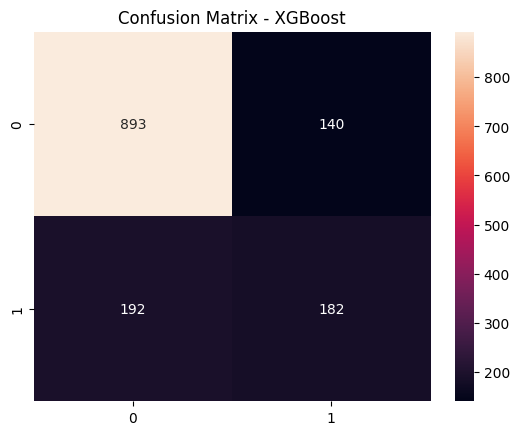

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [23]:
# Save best model
joblib.dump(xgb, "churn_model.pkl")

['churn_model.pkl']

Class Imbalance Handling + Proper Preprocessing

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from xgboost import XGBClassifier



In [36]:
# Load dataset
df = pd.read_csv("Churn.csv")



In [37]:
# Drop ID
if "customerID" in df.columns:
    df.drop("customerID", axis=1, inplace=True)


In [38]:
# Fix TotalCharges
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df.dropna(inplace=True)


In [39]:
# Encode categorical
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])


Class Distribution:
 Churn
0    5163
1    1869
Name: count, dtype: int64


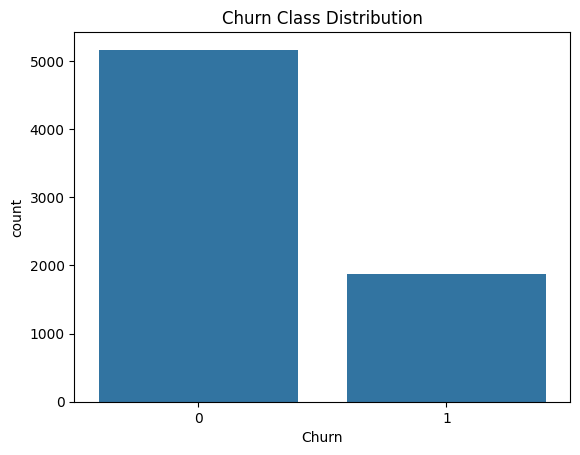

In [40]:
# Check class imbalance
print("Class Distribution:\n", df["Churn"].value_counts())

sns.countplot(x=df["Churn"])
plt.title("Churn Class Distribution")
plt.show()

Train-Test Split

In [28]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Hyperparameter Tuning

In [29]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1]
}

xgb = XGBClassifier(eval_metric="logloss")

grid_search = GridSearchCV(
    xgb,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


Cross Validation Score

In [30]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring="roc_auc")
print("Cross Validation ROC-AUC:", cv_scores.mean())


Cross Validation ROC-AUC: 0.8440406916448433


Final Evaluation

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

ROC-AUC: 0.8355382019040125


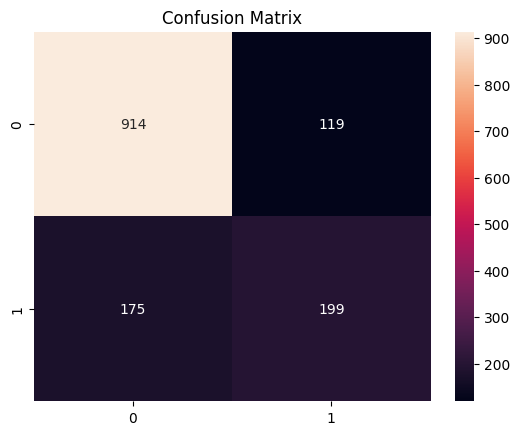

In [31]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


Feature Importance Graph

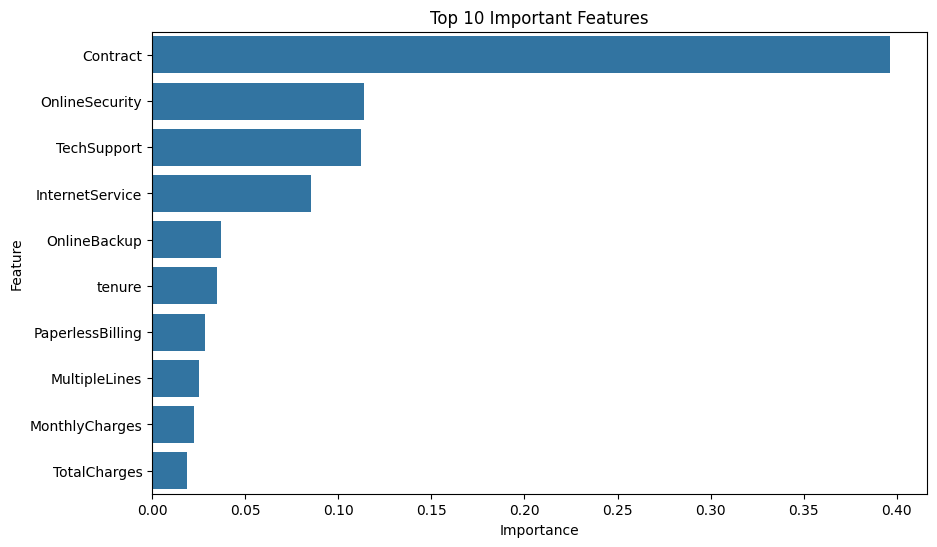

In [32]:
importances = best_model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
plt.title("Top 10 Important Features")
plt.show()


Save Model

In [33]:
joblib.dump(best_model, "production_churn_model.pkl")


['production_churn_model.pkl']